<a href="https://colab.research.google.com/github/ryyutku/DSGP/blob/anuk/Modelling/Model%209/model9_10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Train: (527, 30, 20), Val: (112, 30, 20), Test: (114, 30, 20)
Epoch 1/50


<ipython-input-2-e09aea68ff5a>:23: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.fillna(method='ffill', inplace=True)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.1484 - val_loss: 0.0467
Epoch 2/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0577 - val_loss: 0.0394
Epoch 3/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0327 - val_loss: 0.0308
Epoch 4/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0235 - val_loss: 0.0237
Epoch 5/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0195 - val_loss: 0.0210
Epoch 6/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0185 - val_loss: 0.0185
Epoch 7/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0148 - val_loss: 0.0162
Epoch 8/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0147 - val_loss: 0.0158
Epoch 9/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0139 - val_loss: 0.0143
Epoch 10/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0127 - val_loss: 0.0138
Epoch 11/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0133 - val_loss: 0.0141
Epoch 12/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0108 - val_loss: 0

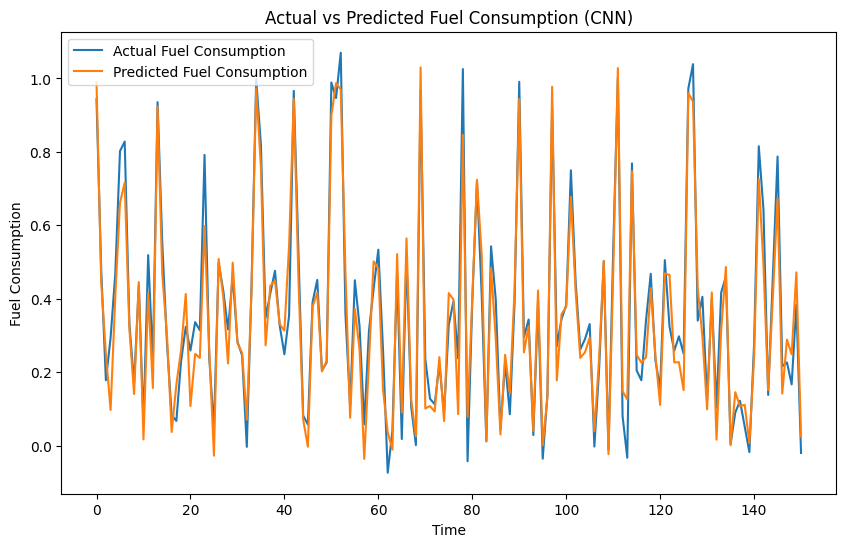

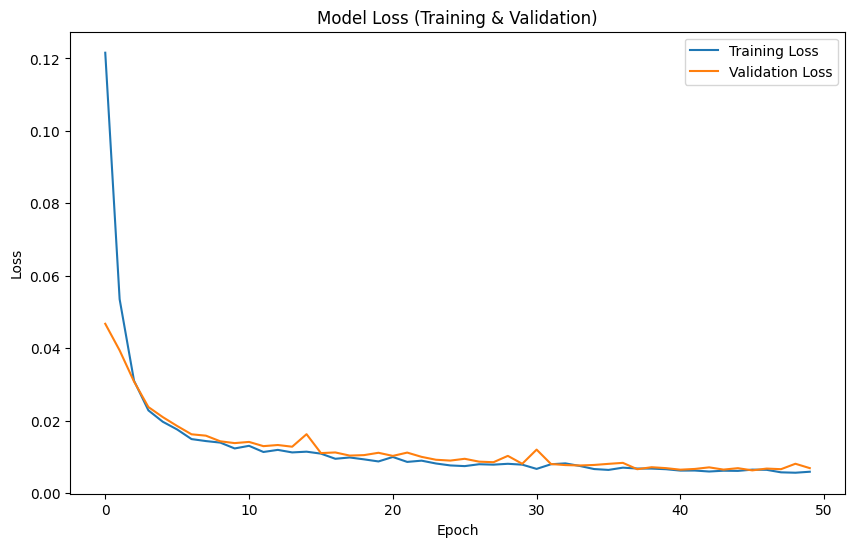

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# 1. Load the dataset
data = pd.read_csv('ciec_data.csv')

# 2. Data Preprocessing
# Drop irrelevant columns
data = data.drop(columns=['Unnamed: 0'])

# Convert date to datetime and set as index
data['date'] = pd.to_datetime(data['date'])
data.set_index('date', inplace=True)

# Fill missing values (if any) with forward fill
data.fillna(method='ffill', inplace=True)

# Define the target variable (fuel consumption) and features
target_column = 'fuel_consumption'
features = data.drop(columns=[target_column])

# Normalize the features using MinMaxScaler
scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(features)
scaled_target = scaler.fit_transform(data[[target_column]])

# 3. Add noise to the data (to reduce the R2 score)
noise_factor = 0.05  # You can adjust this to control the amount of noise
noise = np.random.normal(0, noise_factor, size=scaled_features.shape)
scaled_features_noisy = scaled_features + noise

# Add noise to the target variable
noise_target = np.random.normal(0, noise_factor, size=scaled_target.shape)
scaled_target_noisy = scaled_target + noise_target

# 4. Reshape data for CNN (samples, timesteps, features)
def create_dataset(features, target, time_steps=1):
    X, y = [], []
    for i in range(time_steps, len(features)):
        X.append(features[i - time_steps:i, :])
        y.append(target[i])
    return np.array(X), np.array(y)

time_steps = 30  # Use 30 past time steps to predict the next
X, y = create_dataset(scaled_features_noisy, scaled_target_noisy, time_steps)

# Determine split sizes
total_samples = X.shape[0]
train_size = int(total_samples * 0.7)
val_size = int(total_samples * 0.15)
test_size = total_samples - train_size - val_size

# Chronological split (time-based)
X_train = X[:train_size]
y_train = y[:train_size]

X_val = X[train_size:train_size + val_size]
y_val = y[train_size:train_size + val_size]

X_test = X[train_size + val_size:]
y_test = y[train_size + val_size:]

print(f"Train: {X_train.shape}, Val: {X_val.shape}, Test: {X_test.shape}")


# 5. Train/Test Split (Shuffle the data before splitting)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

# 6. Build the CNN model
# 6. Build the CNN model
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.3))
model.add(Flatten())
model.add(Dense(units=1))
model.compile(optimizer=Adam(), loss='mean_squared_error')

# 7. Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_val, y_val), verbose=1)



# 8. Evaluate the model
y_pred = model.predict(X_test)

# 9. Metrics evaluation
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error (MSE):", mse)
print("Mean Absolute Error (MAE):", mae)
print("R-Squared (R2):", r2)

# Plotting actual vs predicted fuel consumption
plt.figure(figsize=(10, 6))
plt.plot(y_test, label='Actual Fuel Consumption')
plt.plot(y_pred, label='Predicted Fuel Consumption')
plt.title('Actual vs Predicted Fuel Consumption (CNN)')
plt.xlabel('Time')
plt.ylabel('Fuel Consumption')
plt.legend()
plt.show()

# 10. Plot training & validation loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss (Training & Validation)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [3]:
# Predict on final test set
y_pred_test = model.predict(X_test)

# Inverse transform predictions and actual values
# Prepare dummy feature values to inverse transform
repeated_features_test = np.repeat([features.iloc[-1].values], len(y_pred_test), axis=0)

# Inverse scale predicted
combined_pred = np.hstack((repeated_features_test, y_pred_test))
predicted_values = scaler.inverse_transform(combined_pred)[:, -1]

# Inverse scale true values
combined_true = np.hstack((repeated_features_test, y_test))
true_values = scaler.inverse_transform(combined_true)[:, -1]


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


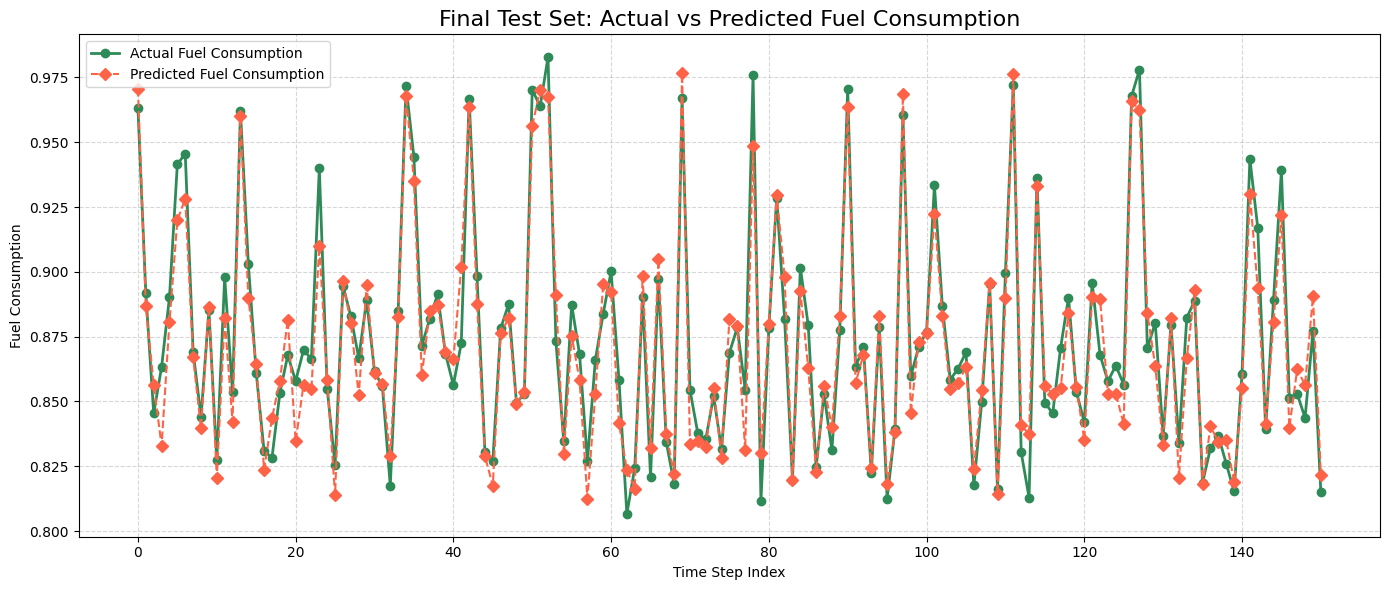

In [4]:
plt.figure(figsize=(14, 6))
plt.plot(true_values, label='Actual Fuel Consumption', color='seagreen', linewidth=2, marker='o')
plt.plot(predicted_values, label='Predicted Fuel Consumption', color='tomato', linestyle='--', marker='D')
plt.title('Final Test Set: Actual vs Predicted Fuel Consumption', fontsize=16)
plt.xlabel('Time Step Index')
plt.ylabel('Fuel Consumption')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()
